# MLBox

#### MLBox is a powerful Automated Machine Learning python library. It provides the following features:

1. Fast reading and distributed data preprocessing/cleaning/formatting
2. Highly robust feature selection and leak detection
3. Accurate hyper-parameter optimization in high-dimensional space
4. State-of-the art predictive models for classification and regression (Deep Learning, Stacking, LightGBM,…)
5. Prediction with models interpretation

# Install Libraries

In [1]:
pip install mlbox

Note: you may need to restart the kernel to use updated packages.Collecting mlbox
  Using cached mlbox-0.8.5.tar.gz (31 kB)
  Using cached numpy-1.18.2-cp38-cp38-win_amd64.whl (12.8 MB)
  Using cached scipy-1.4.1-cp38-cp38-win_amd64.whl (31.0 MB)
  Using cached matplotlib-3.0.3.tar.gz (36.6 MB)
  Using cached hyperopt-0.2.3-py3-none-any.whl (1.9 MB)
  Using cached pandas-0.25.3-cp38-cp38-win_amd64.whl (9.4 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached scikit_learn-0.22.1-cp38-cp38-win_amd64.whl (6.4 MB)



ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0 (from mlbox) (from versions: 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==2.0.0 (from mlbox)


# importing the MLBox

In [1]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

Using Theano backend.
/home/datageek/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
paths = ["train_regression.csv", "test_regression.csv"]
target_name = "SalePrice"

# reading and cleaning all files 

In [3]:
rd = Reader(sep = ',')
df = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data ...
CPU time: 0.870355129242 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.817306995392 seconds

> Number of common features : 80

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 43
> Number of numerical features: 37
> Number of training samples : 1460
> Number of test samples : 1459

> Top sparse features (% missing values on train set):
PoolQC         99.5
MiscFeature    96.3
Alley          93.8
Fence          80.8
FireplaceQu    47.3
dtype: float64

> Task : regression
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [4]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts ...
CPU time: 0.694604873657 seconds

> Top 10 drifts

('Id', 0.9993141289437586)
('GarageYrBlt', 0.058603155187046063)
('Exterior1st', 0.051728220022389637)
('TotalBsmtSF', 0.047797384757831907)
('2ndFlrSF', 0.042466584861516665)
('Exterior2nd', 0.042145856162453033)
('BsmtFullBath', 0.040377812116377587)
('GrLivArea', 0.039437274266823197)
('TotRmsAbvGrd', 0.038939865235153803)
('WoodDeckSF', 0.037307853783462352)

> Deleted variables : ['Id']
> Drift coefficients dumped into directory : save


# tuning

In [5]:
mape = make_scorer(lambda y_true, y_pred: 100*np.sum(np.abs(y_true-y_pred)/y_true)/len(y_true), greater_is_better=False, needs_proba=False)
opt = Optimiser(scoring = mape, n_folds = 3)

/home/datageek/anaconda2/lib/python2.7/site-packages/mlbox/optimisation/optimiser.py:78: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [6]:
opt.evaluate(None, df)

No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'colsample_bytree': 0.8, 'silent': True, 'max_depth': -1, 'learning_rate': 0.05, 'nthread': -1, 'min_child_weight': 5, 'strategy': 'LightGBM', 'n_estimators': 500, 'subsample': 0.9, 'reg_lambda': 0, 'subsample_freq': 1, 'max_bin': 255, 'objective': 'regression', 'min_split_gain': 0, 'seed': 0, 'min_child_samples': 10, 'boosting_type': 'gbdt'}


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -16.5501726299
VARIANCE : 2.00925690187 (fold 1 = -19.3633082808, fold 2 = -15.4905497623, fold 3 = -14.7966598466)
CPU time: 7.96322011948 seconds



-16.550172629917437

In [8]:
space = {
    
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding","random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.01,0.3]},    
        'est__max_depth':{"search":"choice",
                                  "space":[3,4,5,6,7]}
    
        }

best = opt.optimise(space, df, 15)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'threshold': 0.07553727171443735, 'strategy': 'l1'}

>>> ESTIMATOR :{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'colsample_bytree': 0.8, 'silent': True, 'learning_rate': 0.05, 'nthread': -1, 'min_child_weight': 5, 'strategy': 'LightGBM', 'n_estimators': 500, 'subsample': 0.9, 'reg_lambda': 0, 'subsample_freq': 1, 'min_child_samples': 10, 'max_bin': 255, 'objective': 'regression', 'min_split_gain': 0, 'seed': 0, 'max_depth': 5, 'boosting_type': 'gbdt'}



/home/datageek/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -17.0131701568
VARIANCE : 1.94422752181 (fold 1 = -19.7231981208, fold 2 = -16.0604524723, fold 3 = -15.2558598775)
CPU time: 9.01879310608 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'threshold': 0.2712770562069091, 'strategy': 'l1'}

>>> ESTIMATOR :{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'colsample_bytree': 0.8, 'silent': True, 'learning_rate': 0.05, 'nthread': -1, 'min_child_weight': 5, 'strategy': 'LightGBM', 'n_estimators': 500, 'subsample': 0.9, 'reg_lambda': 0, 'subsample_freq': 1, 'min_child_samples': 10, 'max_bin': 255, 'objective': 'regression', 'min_split_gain': 0, 'seed': 0, 'max_depth': 7, 'boosting_type': 'gbdt'}


MEAN SCORE : make_score


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -18.2243140592
VARIANCE : 1.85042772549 (fold 1 = -20.8171897448, fold 2 = -17.2342598159, fold 3 = -16.6214926168)
CPU time: 8.42891383171 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.22805780286080266, 'strategy': 'l1'}

>>> ESTIMATOR :{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'colsample_bytree': 0.8, 'silent': True, 'learning_rate': 0.05, 'nthread': -1, 'min_child_weight': 5, 'strategy': 'LightGBM', 'n_estimators': 500, 'subsample': 0.9, 'reg_lambda': 0, 'subsample_freq': 1, 'min_child_samples': 10, 'max_bin': 255, 'objective': 'regression', 'min_split_gain': 0, 'seed': 0, 'max_depth': 3, 'boosting_type': 'gbdt'}


MEAN SCORE : make_scorer(


fitting the pipeline ...
CPU time: 24.3019030094 seconds


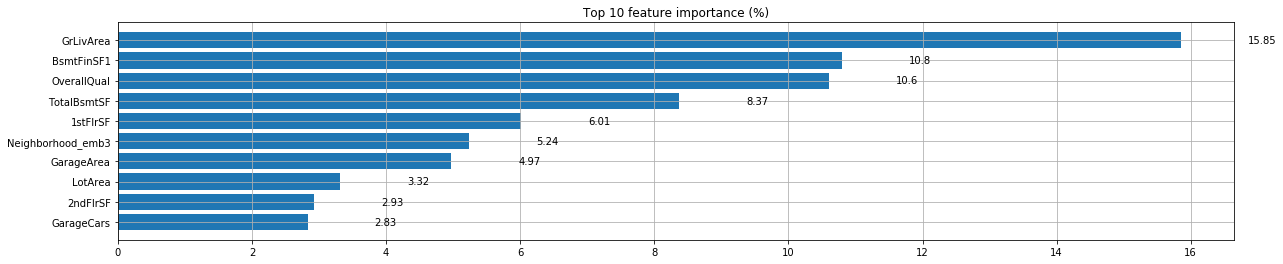


> Feature importances dumped into directory : save

predicting...
CPU time: 0.247318983078 seconds

> Overview on predictions : 

   SalePrice_predicted
0        134044.028235
1        144594.881585
2        180050.531399
3        181463.178663
4        202005.069875
5        178437.609779
6        171465.485935
7        172144.412085
8        186061.406054
9        133123.267499

dumping predictions into directory : save ...


<mlbox.prediction.predictor.Predictor instance at 0x7f672fb2f098>

In [9]:
prd = Predictor()
prd.fit_predict(best, df)